## Graph: BF
This uses the pkl outputs from the salabim and slurmtrain notebooks

TODO: 
- [x] FIX STRAIN BACKFILL DICT ... ENTRY 1 ISNOT RIGHT (8prio something)
- [ ] LOAD SLURM SIM AND COMBINE WAITING TIME TABLE 
- [ ] Add diag_start and diag_end creation to run_job_trace script
- [ ] Automate X_batch salabim model
- [ ] Automate X_batch slurmtrain data

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import stats
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import matplotlib.pylab as pylab

# size: Either a relative value of 'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large' 
#     or an absolute font size, e.g., 10. Default: rcParams["font.size"] (default: 10.0)

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [3]:
# Setup Paths
path_slurmtrain = Path(r"/home/overlytic/thesis/notebooks/slurm_train/output/sacct")
path_slurmsim = Path(r"/mnt/wsl/instances/Ubuntu-18.04//home/slurm/slurm_sim_ws/slurm_sim_tools/slurm_batches/simple_traces/srun")

In [4]:
# Parameters

myrun_short_id = "bf138"

# Base run 
myrun_type0 = "fiforun"
myrun_shortname0 = f"{myrun_type0}_{myrun_short_id}"

# Main run
myrun_type = "bfrun"
myrun_shortname = f"{myrun_type}_{myrun_short_id}"

print(f"myrun_shortname0: {myrun_shortname0}")
print(f"myrun_shortname: {myrun_shortname}")

# Main Metrics for 'wait table all metrics'
metrics = ['min', 'max',  'std', 'mean']
metric_names = ['min', 'max', '$s_{dev}$', 'average']

myrun_shortname0: fiforun_bf138
myrun_shortname: bfrun_bf138


In [5]:
# myrun_savepath = Path('.') / myrun_type / myrun_shortname
# print(f"Output folder: {myrun_savepath}")

In [6]:
# Paths
thesis_path = Path(".")
save_image_path = thesis_path / "images" / "results"
save_data_path = thesis_path / "images" / "data"

In [7]:
# Helper functions

def extract_run_num(f, run_type):
    """
    f : string filename e.g. srun8_fiforun_2jt-run30-rho60-run10_slurmtrain_dfacct
    Result : '10' on error return -1
    """
    run_search = re.search(f".*-run(.*)_{run_type}.*.pkl", f)
    
    run = -1 # default
    
    if run_search:
        srun = run_search.group(1)
        
        if srun.isdigit():
            run = int(srun)
        
    return run
    

In [8]:
# write the above as a function ... quickly ... 
def load_run_filelist(myrun_shortname, myrun_model, myrun_filename, folder_path=save_data_path, sort=True, return_detail=False):
    
    file_search_string = f'*{myrun_shortname}*run[0-9]*_{myrun_model}*{myrun_filename}'
    filelist_all = list(folder_path.glob(file_search_string))

    if filelist_all:
        # Extract run numbers
        run_nums_all = [extract_run_num(p.name, myrun_model) for p in filelist_all]
        
        if sort: 
            # Sort paths based on valid run numbers
            ind_sort = np.argsort(run_nums_all)
            ind_sort_valid = [ind_sort[i] for i, value in enumerate(run_nums_all) if value > 0]
            run_nums_sorted = [run_nums_all[i] for i in ind_sort_valid]
            filelist_sorted = [filelist_all[i] for i in ind_sort_valid]
                        
            if return_detail:
                return filelist_sorted, run_nums_sorted, file_search_string  
            else:
                return filelist_sorted
        
        else:
            if return_detail:
                return filelist_all, run_nums_all, file_search_string 
            else: 
                return filelist_all
        
    else:
        
        if return_detail:
            return [], [], file_search_string
        else: 
            return []

In [9]:
# Example for laoding runs:
strain_dfacct_sorted, strain_run_nums, strain_searchstring = load_run_filelist(myrun_shortname, "slurmtrain", "dfacct.pkl", return_detail=True)

if strain_dfacct_sorted: 
    print(f"slurmtrain runs count: {len(strain_run_nums)}")
    print(f"slurmtrain run nums: {strain_run_nums}")
    for x in strain_dfacct_sorted: print(x)
else: 
    print(f"No files found for search string: {strain_search_string}\n in path: {save_data_path.absolute()}")

slurmtrain runs count: 10
slurmtrain run nums: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
images/data/srun8_bfrun_bf138-run1_slurmtrain_dfacct.pkl
images/data/srun8_bfrun_bf138-run2_slurmtrain_dfacct.pkl
images/data/srun8_bfrun_bf138-run3_slurmtrain_dfacct.pkl
images/data/srun8_bfrun_bf138-run4_slurmtrain_dfacct.pkl
images/data/srun8_bfrun_bf138-run5_slurmtrain_dfacct.pkl
images/data/srun8_bfrun_bf138-run6_slurmtrain_dfacct.pkl
images/data/srun8_bfrun_bf138-run7_slurmtrain_dfacct.pkl
images/data/srun8_bfrun_bf138-run8_slurmtrain_dfacct.pkl
images/data/srun8_bfrun_bf138-run9_slurmtrain_dfacct.pkl
images/data/srun8_bfrun_bf138-run10_slurmtrain_dfacct.pkl


# Load Run File List

## SlurmTrain

### FIFO Runs (for reference)

In [10]:
strain_fifo_dfacct_sorted = load_run_filelist(myrun_shortname0, "slurmtrain", "dfacct.pkl")
strain_fifo_dfpetime_sorted = load_run_filelist(myrun_shortname0, "slurmtrain", "dfpetime.pkl")

print(f"strain_fifo_dfacct_sorted: {len(strain_fifo_dfacct_sorted)}")
print(f"strain_fifo_dfacct_sorted: {len(strain_fifo_dfacct_sorted)}")

strain_fifo_dfacct_sorted: 10
strain_fifo_dfacct_sorted: 10


### BF Runs

In [11]:
strain_bf_dfacct_sorted = load_run_filelist(myrun_shortname, "slurmtrain", "dfacct.pkl")
strain_bf_dfpetime_sorted = load_run_filelist(myrun_shortname, "slurmtrain", "dfpetime.pkl")
strain_bf_dictbackfill_sorted = load_run_filelist(myrun_shortname, "slurmtrain", "dictbackfill.pkl")

print(f"strain_bf_dfacct_sorted: {len(strain_bf_dfacct_sorted)}")
print(f"strain_bf_dfpetime_sorted: {len(strain_bf_dfpetime_sorted)}")
print(f"strain_bf_dictbackfill_sorted: {len(strain_bf_dictbackfill_sorted)}")

strain_bf_dictbackfill_sorted

strain_bf_dfacct_sorted: 10
strain_bf_dfpetime_sorted: 10
strain_bf_dictbackfill_sorted: 10


[PosixPath('images/data/srun8_bfrun_bf138-run1_slurmtrain_dictbackfill.pkl'),
 PosixPath('images/data/srun8_bfrun_bf138-run2_slurmtrain_dictbackfill.pkl'),
 PosixPath('images/data/srun8_bfrun_bf138-run3_slurmtrain_dictbackfill.pkl'),
 PosixPath('images/data/srun8_bfrun_bf138-run4_slurmtrain_dictbackfill.pkl'),
 PosixPath('images/data/srun8_bfrun_bf138-run5_slurmtrain_dictbackfill.pkl'),
 PosixPath('images/data/srun8_bfrun_bf138-run6_slurmtrain_dictbackfill.pkl'),
 PosixPath('images/data/srun8_bfrun_bf138-run7_slurmtrain_dictbackfill.pkl'),
 PosixPath('images/data/srun8_bfrun_bf138-run8_slurmtrain_dictbackfill.pkl'),
 PosixPath('images/data/srun8_bfrun_bf138-run9_slurmtrain_dictbackfill.pkl'),
 PosixPath('images/data/srun8_bfrun_bf138-run10_slurmtrain_dictbackfill.pkl')]

## Salabim

### FIFO Runs (for reference)

In [12]:
sala_fifo_dfjobs_sorted = load_run_filelist(myrun_shortname0, "salabim", "dfjobs.pkl")
sala_fifo_dfpetime_sorted = load_run_filelist(myrun_shortname0, "salabim", "dfpetime.pkl")

print(f"sala_fifo_dfjobs_sorted: {len(sala_fifo_dfjobs_sorted)}")
print(f"sala_fifo_dfpetime_sorted: {len(sala_fifo_dfpetime_sorted)}")

sala_fifo_dfjobs_sorted: 10
sala_fifo_dfpetime_sorted: 10


### BF Runs

In [13]:
sala_bf_dfjobs_sorted = load_run_filelist(myrun_shortname, "salabim", "dfjobs.pkl")
sala_bf_dfpetime_sorted = load_run_filelist(myrun_shortname, "salabim", "dfpetime.pkl")

print(f"sala_bf_dfjobs_sorted: {len(sala_bf_dfjobs_sorted)}")
print(f"sala_bf_dfpetime_sorted: {len(sala_bf_dfpetime_sorted)}")

sala_bf_dfjobs_sorted: 10
sala_bf_dfpetime_sorted: 10


## SlurmSim

### BF Runs

In [14]:
slurmsim_bf_dfacct_sorted = load_run_filelist(myrun_shortname, "slurmsim", "dfacct.pkl")
slurmsim_bf_dfpetime_sorted = load_run_filelist(myrun_shortname, "slurmsim", "dfpetime.pkl")
slurmsim_bf_dictbackfill_sorted = load_run_filelist(myrun_shortname, "slurmtrain", "dictbackfill.pkl")

print(f"slurmsim_bf_dfacct_sorted: {len(slurmsim_bf_dfacct_sorted)}")
print(f"slurmsim_bf_dfpetime_sorted: {len(slurmsim_bf_dfpetime_sorted)}")
print(f"slurmsim_bf_dictbackfill_sorted: {len(slurmsim_bf_dictbackfill_sorted)}")

# slurmsim_bf_dictbackfill_sorted

slurmsim_bf_dfacct_sorted: 10
slurmsim_bf_dfpetime_sorted: 10
slurmsim_bf_dictbackfill_sorted: 10


# Load Runs

In [15]:
def calc_strain_wait(sacct_df):
    
    sacct_df.pe_req = sacct_df.pe_req.round(0).astype(int)
    
    wait_table = (sacct_df
     .loc[:, ['Account', 'JobName', 'pe_req', 'wait_time', 'elapsed_time']]
     .assign(job_prio =
             lambda x: np.select([x.Account == "training", x.Account=="crucial"],
                                 [1, 10]))
     .rename(columns = {'elapsed_time':'run_time',
                        'pe_req': 'job_pe_req',
                        'JobName' : 'job_number'})
     .groupby(['job_prio', 'job_pe_req'])
#       .groupby(['job_prio'])
      .agg({
           "wait_time": ["mean"],
           "run_time" : ["mean"],
           "job_number" : ["count"] #,
           # "backfill" : ["sum"]
            })
     .reset_index()
    )
    
    wait_table.columns = wait_table.columns.map("_".join).str.strip('_')
    
    return wait_table

# # # Test:
# sacct_df = pd.read_pickle(strain_dfacct_sorted[0], compression='infer')
# w_strain = calc_strain_wait(sacct_df)
# w_strain

In [16]:
def calc_sala_wait(df_jobs):
    
    df_jobs.job_pe_req = df_jobs.job_pe_req.round(0).astype(int)
    
    wait_table = (df_jobs
    #      .merge(df_job_idx, on="job_name", how="inner")
                  .loc[:, ['job_number', 'job_pe_req', 
                           'job_prio', 'wait_time', 'run_time', 
                           'backfill']]
                   .groupby(['job_prio', 'job_pe_req'])
#                   .groupby(['job_prio'])                  
                  .agg({
           "wait_time": ["mean"],
           "run_time" : ["mean"],
#            "job_pe_req" : ["mean"],
           "job_number" : ["count"],
           "backfill" : ["sum"]
            })
     .reset_index())

    wait_table.columns = wait_table.columns.map("_".join).str.strip('_')

    return(wait_table)
    
# # Test
# df_jobs = pd.read_pickle(salabim_dfjobs_sorted[0])
# w_sala = calc_sala_wait(df_jobs)
# w_sala

## SlurmTrain Runs

In [17]:
range(len(strain_fifo_dfacct_sorted))

range(0, 10)

In [18]:
# Read SlurmTrain FIFO Runs and make table with wait times

strain_fifo_lst_wait = []

num_runs = len(strain_fifo_dfacct_sorted)

load_bf = False
list_sacct = strain_fifo_dfacct_sorted
list_petime = strain_fifo_dfpetime_sorted
list_bf = None

dic_st_fifo_sacct = {}
dic_st_fifo_petime = {}
dic_st_fifo_bfdata = None

for i in range(num_runs):
    
    # SAcct
    sacct_path = list_sacct[i]
    df_sacct = pd.read_pickle(sacct_path)
    dic_st_fifo_sacct[i] = df_sacct
    
    # PE Time
    petime_path = list_petime[i]
    df_petime = pd.read_pickle(petime_path)    
    dic_st_fifo_petime[i] = df_petime
    
    # Calc Wait Time
    strain_wait = calc_strain_wait(df_sacct)    

    # BF Info
    if load_bf:
        bf_path = list_bf[i]
        dic_bf = pd.read_pickle(bf_path)
        dic_st_fifo_bfdata[i] = dic_bf
        strain_wait['Total_run_backfills'] = dic_bf['backfill_count']
    else: 
        strain_wait['Total_run_backfills'] = 0
    
    # Other Info
    strain_wait['RunNum'] = i+1
    strain_wait['RunType'] = 'slurmtrain'
    strain_wait['SchedType'] = 'FIFO'
    
    
    strain_fifo_lst_wait.append(strain_wait)
    
df_wait_fifo_strain = pd.concat(strain_fifo_lst_wait)

df_wait_fifo_strain.head(10)

,job_prio,job_pe_req,wait_time_mean,run_time_mean,job_number_count,Total_run_backfills,RunNum,RunType,SchedType
0,1,1,300.188679,32.452830,106,0,1,slurmtrain,FIFO
1,1,3,324.956044,60.637363,91,0,1,slurmtrain,FIFO
2,1,8,215.666667,51.000000,3,0,1,slurmtrain,FIFO
0,1,1,15.466019,29.737864,103,0,2,slurmtrain,FIFO
1,1,3,20.842105,56.778947,95,0,2,slurmtrain,FIFO
2,1,8,89.500000,19.000000,2,0,2,slurmtrain,FIFO
0,1,1,82.714286,33.959184,98,0,3,slurmtrain,FIFO
1,1,3,85.690000,57.390000,100,0,3,slurmtrain,FIFO
2,1,8,83.500000,83.000000,2,0,3,slurmtrain,FIFO
0,1,1,38.990196,34.235294,102,0,4,slurmtrain,FIFO


In [19]:
# Read SlurmTrain BF Runs and make table with wait times

strain_bf_lst_wait = []

num_runs = len(strain_bf_dfacct_sorted)

load_bf = True
list_sacct = strain_bf_dfacct_sorted
list_petime = strain_bf_dfpetime_sorted
list_bf = strain_bf_dictbackfill_sorted

dic_st_bf_sacct = {}
dic_st_bf_petime = {}
dic_st_bf_bfdata = {}

for i in range(num_runs):
    
    # SAcct
    sacct_path = list_sacct[i]
    df_sacct = pd.read_pickle(sacct_path)
    dic_st_bf_sacct[i] = df_sacct
    
    # PE Time
    petime_path = list_petime[i]
    df_petime = pd.read_pickle(petime_path)    
    dic_st_bf_petime[i] = df_petime
    
    # BF Info
    if load_bf:
        bf_path = list_bf[i]
        dic_bf = pd.read_pickle(bf_path)   # FIX THIS
        dic_st_bf_bfdata[i] = dic_bf
    
    # Calc Wait Time
    strain_wait = calc_strain_wait(df_sacct)        
    
    if load_bf: 
        strain_wait['Total_run_backfills'] = dic_bf['backfill_count']
    else: 
        strain_wait['Total_run_backfills'] = 0
        
    strain_wait['RunNum'] = i+1    
    strain_wait['RunType'] = 'slurmtrain'
    strain_wait['SchedType'] = 'BF'
    
    strain_bf_lst_wait.append(strain_wait)
    
df_wait_bf_strain = pd.concat(strain_bf_lst_wait)

df_wait_bf_strain.head(10)

,job_prio,job_pe_req,wait_time_mean,run_time_mean,job_number_count,Total_run_backfills,RunNum,RunType,SchedType
0,1,1,269.669811,32.500000,106,12,1,slurmtrain,BF
1,1,3,304.670330,60.637363,91,12,1,slurmtrain,BF
2,1,8,201.666667,51.333333,3,12,1,slurmtrain,BF
0,1,1,13.000000,29.660194,103,5,2,slurmtrain,BF
1,1,3,20.705263,56.726316,95,5,2,slurmtrain,BF
2,1,8,89.500000,19.500000,2,5,2,slurmtrain,BF
0,1,1,68.969388,34.000000,98,17,3,slurmtrain,BF
1,1,3,84.690000,57.440000,100,17,3,slurmtrain,BF
2,1,8,88.500000,82.500000,2,17,3,slurmtrain,BF
0,1,1,22.598039,34.264706,102,16,4,slurmtrain,BF


## Salabim Runs

In [20]:
# Read SlurmTrain FIFO Runs and make table with wait times

sala_fifo_lst_wait = []

num_runs = len(sala_bf_dfjobs_sorted)

list_jobs = sala_fifo_dfjobs_sorted
list_petime = sala_fifo_dfpetime_sorted

dic_sala_fifo_dfjobs = {}
dic_sala_fifo_petime = {}

for i in range(num_runs):
    
    # SAcct
    dfjobs_path = list_jobs[i]
    df_jobs = pd.read_pickle(dfjobs_path)
    dic_sala_fifo_dfjobs[i] = df_jobs
    
    # PE Time
    petime_path = list_petime[i]
    df_petime = pd.read_pickle(petime_path)    
    dic_sala_fifo_petime[i] = df_petime
        
    # Calc Wait Time
    sala_wait = calc_sala_wait(df_jobs)
        
    sala_wait['Total_run_backfills'] = sala_wait.backfill_sum.sum()
        
    sala_wait['RunNum'] = i+1
    sala_wait['RunType'] = 'salabim'
    sala_wait['SchedType'] = 'FIFO'
    
    
    sala_fifo_lst_wait.append(sala_wait)
    
df_wait_fifo_sala = pd.concat(sala_fifo_lst_wait)

df_wait_fifo_sala.head(10)

,job_prio,job_pe_req,wait_time_mean,run_time_mean,job_number_count,backfill_sum,Total_run_backfills,RunNum,RunType,SchedType
0,1,1,297.283019,32.301887,106,0,0,1,salabim,FIFO
1,1,3,322.175824,60.428571,91,0,0,1,salabim,FIFO
2,1,8,213.000000,51.000000,3,0,0,1,salabim,FIFO
0,1,1,14.631068,29.495146,103,0,0,2,salabim,FIFO
1,1,3,19.936842,56.536842,95,0,0,2,salabim,FIFO
2,1,8,88.000000,19.000000,2,0,0,2,salabim,FIFO
0,1,1,81.479592,33.724490,98,0,0,3,salabim,FIFO
1,1,3,84.310000,57.220000,100,0,0,3,salabim,FIFO
2,1,8,82.500000,82.500000,2,0,0,3,salabim,FIFO
0,1,1,38.254902,34.049020,102,0,0,4,salabim,FIFO


In [21]:
# Read SlurmTrain FIFO Runs and make table with wait times

sala_bf_lst_wait = []

num_runs = len(sala_bf_dfjobs_sorted)

list_jobs = sala_bf_dfjobs_sorted
list_petime = sala_bf_dfpetime_sorted

dic_sala_bf_dfjobs = {}
dic_sala_bf_petime = {}

for i in range(num_runs):
    
    # SAcct
    dfjobs_path = list_jobs[i]
    df_jobs = pd.read_pickle(dfjobs_path)
    dic_sala_bf_dfjobs[i] = df_jobs
    
    # PE Time
    petime_path = list_petime[i]
    df_petime = pd.read_pickle(petime_path)    
    dic_sala_bf_petime[i] = df_petime
        
    # Calc Wait Time
    sala_wait = calc_sala_wait(df_jobs)
        
    sala_wait['Total_run_backfills'] = sala_wait.backfill_sum.sum()
        
    sala_wait['RunNum'] = i+1
    sala_wait['RunType'] = 'salabim'
    sala_wait['SchedType'] = 'BF'
    
    
    sala_bf_lst_wait.append(sala_wait)
    
df_wait_bf_sala = pd.concat(sala_bf_lst_wait)

df_wait_bf_sala.head(10)

,job_prio,job_pe_req,wait_time_mean,run_time_mean,job_number_count,backfill_sum,Total_run_backfills,RunNum,RunType,SchedType
0,1,1,25.349057,32.301887,106,78,94,1,salabim,BF
1,1,3,247.065934,60.428571,91,16,94,1,salabim,BF
2,1,8,294.666667,51.000000,3,0,94,1,salabim,BF
0,1,1,2.524272,29.495146,103,34,37,2,salabim,BF
1,1,3,20.210526,56.536842,95,3,37,2,salabim,BF
2,1,8,172.000000,19.000000,2,0,37,2,salabim,BF
0,1,1,3.816327,33.724490,98,52,83,3,salabim,BF
1,1,3,35.680000,57.220000,100,31,83,3,salabim,BF
2,1,8,587.500000,82.500000,2,0,83,3,salabim,BF
0,1,1,3.941176,34.049020,102,39,39,4,salabim,BF


## Slurmsim Runs

In [22]:
# Read SlurmTrain BF Runs and make table with wait times

slurmsim_bf_lst_wait = []

num_runs = len(slurmsim_bf_dfacct_sorted)

load_bf = True
list_sacct = slurmsim_bf_dfacct_sorted
list_petime = slurmsim_bf_dfpetime_sorted
list_bf = slurmsim_bf_dictbackfill_sorted

dic_ss_bf_sacct = {}
dic_ss_bf_petime = {}
dic_ss_bf_bfdata = {}

for i in range(num_runs):
    
    # SAcct
    sacct_path = list_sacct[i]
    df_sacct = pd.read_pickle(sacct_path)
    dic_ss_bf_sacct[i] = df_sacct
    
    # PE Time
    petime_path = list_petime[i]
    df_petime = pd.read_pickle(petime_path)    
    dic_ss_bf_petime[i] = df_petime
    
    # BF Info
    if load_bf:
        bf_path = list_bf[i]
        dic_bf = pd.read_pickle(bf_path)   # FIX THIS
        dic_ss_bf_bfdata[i] = dic_bf
    
    # Calc Wait Time
    slurmsim_wait = calc_strain_wait(df_sacct)        
    
    if load_bf: 
        slurmsim_wait['Total_run_backfills'] = dic_bf['backfill_count']
    else: 
        slurmsim_wait['Total_run_backfills'] = 0
        
    slurmsim_wait['RunNum'] = i+1    
    slurmsim_wait['RunType'] = 'slurmsim'
    slurmsim_wait['SchedType'] = 'BF'
    
    slurmsim_bf_lst_wait.append(slurmsim_wait)
    
df_wait_bf_slurmsim = pd.concat(slurmsim_bf_lst_wait)

df_wait_bf_slurmsim.head(10)

,job_prio,job_pe_req,wait_time_mean,run_time_mean,job_number_count,Total_run_backfills,RunNum,RunType,SchedType
0,1,1,235.500000,32.301887,106,12,1,slurmsim,BF
1,1,3,288.109890,60.428571,91,12,1,slurmsim,BF
2,1,8,191.333333,51.000000,3,12,1,slurmsim,BF
0,1,1,12.058252,29.495146,103,5,2,slurmsim,BF
1,1,3,20.442105,56.536842,95,5,2,slurmsim,BF
2,1,8,89.000000,19.000000,2,5,2,slurmsim,BF
0,1,1,80.091837,33.724490,98,17,3,slurmsim,BF
1,1,3,86.420000,57.220000,100,17,3,slurmsim,BF
2,1,8,89.000000,82.500000,2,17,3,slurmsim,BF
0,1,1,21.284314,34.049020,102,16,4,slurmsim,BF


In [23]:
# Combine data from the salabim and strain

df_wait_combo = pd.concat([df_wait_fifo_strain,
                           df_wait_fifo_sala,
                           df_wait_bf_strain, 
                           df_wait_bf_sala,
                           df_wait_bf_slurmsim])

df_wait_combo

,job_prio,job_pe_req,wait_time_mean,run_time_mean,job_number_count,Total_run_backfills,RunNum,RunType,SchedType,backfill_sum
0,1,1,300.188679,32.452830,106,0,1,slurmtrain,FIFO,NaN
1,1,3,324.956044,60.637363,91,0,1,slurmtrain,FIFO,NaN
2,1,8,215.666667,51.000000,3,0,1,slurmtrain,FIFO,NaN
0,1,1,15.466019,29.737864,103,0,2,slurmtrain,FIFO,NaN
1,1,3,20.842105,56.778947,95,0,2,slurmtrain,FIFO,NaN
...,...,...,...,...,...,...,...,...,...,...
0,1,1,37.125000,33.125000,104,20,9,slurmsim,BF,NaN
1,1,3,71.978495,60.602151,93,20,9,slurmsim,BF,NaN
2,1,8,124.000000,21.333333,3,20,9,slurmsim,BF,NaN
0,1,1,96.860000,30.140000,100,16,10,slurmsim,BF,NaN


In [24]:
# Write csv file
save_csv = True
if save_csv: 
    filename = f"{myrun_shortname}_data.csv"
    df_wait_combo.to_csv(thesis_path / "temp" / filename)

In [25]:
# Check timeouts
for i in range(10):
    df = dic_st_fifo_sacct[i]
    timeout_count = df.loc[df.State != 'COMPLETED', 'State'].value_counts()
    if len(timeout_count) > 0 : print(f"run:{i+1}. fifo, , {timeout_count}\n")

for i in range(10):
    df = dic_st_bf_sacct[i]
    timeout_count = df.loc[df.State != 'COMPLETED', 'State'].value_counts()
    if len(timeout_count) > 0 : print(f"run:{i+1}. bf, , {timeout_count}\n")

run:2. fifo, , TIMEOUT    1
Name: State, dtype: int64

run:5. fifo, , TIMEOUT    1
Name: State, dtype: int64

run:8. fifo, , TIMEOUT    1
Name: State, dtype: int64

run:8. bf, , TIMEOUT    1
Name: State, dtype: int64

run:10. bf, , TIMEOUT    1
Name: State, dtype: int64



## Plots

In [26]:
# Change names for plotting

df_plot = df_wait_combo.copy()

df_plot.loc[(df_plot.RunType == 'salabim'), 'RunType'] = 'SimPE'
df_plot.loc[(df_plot.RunType == 'slurmtrain'), 'RunType'] = 'SlurmTrain'

df_plot = df_plot.rename(columns = {'RunType':'Model'})

df_plot['Job PE'] = df_plot.job_pe_req.astype(str) + " PE"


# Split by Sched Type
df_plot_fifo = df_plot.loc[df_plot.SchedType == 'FIFO']
df_plot_bf = df_plot.loc[df_plot.SchedType == 'BF']


# Version with only 1 and 3 PE. No 8
df_plot_no8 = df_plot.query('job_pe_req != 8').copy()

df_plot.head()

,job_prio,job_pe_req,wait_time_mean,run_time_mean,job_number_count,Total_run_backfills,RunNum,Model,SchedType,backfill_sum,Job PE
0,1,1,300.188679,32.452830,106,0,1,SlurmTrain,FIFO,NaN,1 PE
1,1,3,324.956044,60.637363,91,0,1,SlurmTrain,FIFO,NaN,3 PE
2,1,8,215.666667,51.000000,3,0,1,SlurmTrain,FIFO,NaN,8 PE
0,1,1,15.466019,29.737864,103,0,2,SlurmTrain,FIFO,NaN,1 PE
1,1,3,20.842105,56.778947,95,0,2,SlurmTrain,FIFO,NaN,3 PE


### Backfill

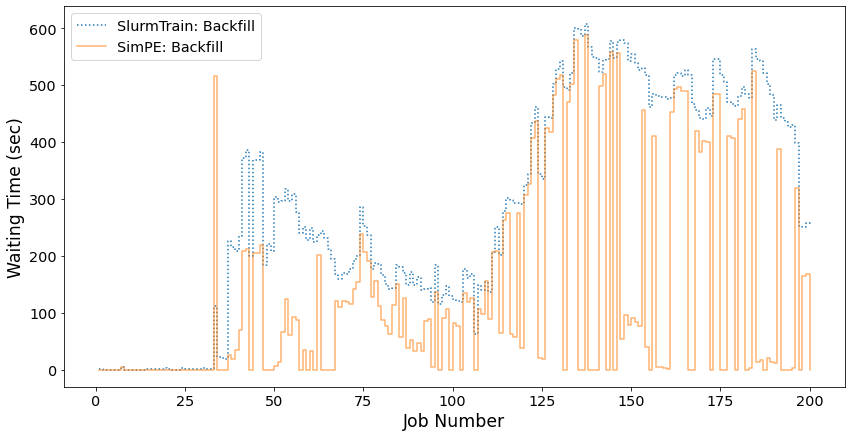

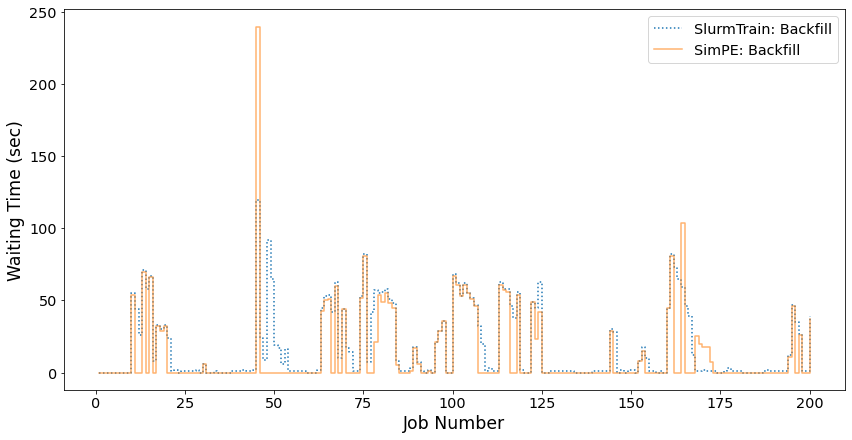

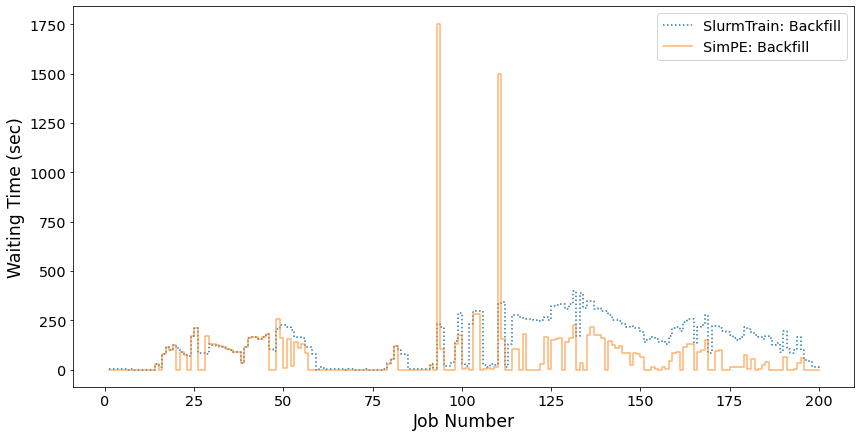

In [27]:
# n = 200
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# runs=range(0,10)
runs = [1,2,6]

for run in runs:
    j = run - 1
    
    fig, ax = plt.subplots(figsize=[14,7])
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    st_acct = dic_st_bf_sacct[j].loc[:, ['JobName', 'wait_time']].copy()
    st_acct['job_name'] = st_acct['JobName'].astype(int)
    st_acct['RunType'] = 'slurmtrain'
    st_acct['SchedType'] = 'BF'

    sala_jobs = dic_sala_bf_dfjobs[j].loc[:, ['job_name', 'wait_time']].copy()
    sala_jobs['job_name'] = sala_jobs['job_name'].astype(int)
    sala_jobs['RunType'] = 'salabim'
    sala_jobs['SchedType'] = 'BF'

    compare_wait = pd.merge(left=sala_jobs, 
                            right=st_acct, 
                            how="inner",
                            on="job_name",
                            suffixes = ("_sala", "_st")
                            )

    compare_wait['Job Number'] = compare_wait.job_name - 1000 + 1


    # Plot
    ax.step(compare_wait['Job Number'], 
        compare_wait.wait_time_st,
        linestyle='dotted',
        where='post',
        label = f"SlurmTrain: Backfill",
        alpha=1)

    # Plot 
    ax.step(compare_wait['Job Number'], 
        compare_wait.wait_time_sala,
        linestyle='solid',
        where='post',
        label = f"SimPE: Backfill",
        alpha=.6)

    ax.legend()
    ax.set_xlabel('Job Number')
    # ax.set_ylabel(r'PE Available / Max PE')
    ax.set_ylabel('Waiting Time (sec)')

    myrun_models = f"{myrun_type}_wait_step_plot_run{run}"
    pltpath = f'{save_image_path}/{myrun_shortname}_{myrun_models}.png'

    plt.savefig(pltpath, facecolor='w', transparent=False, dpi=300)

    plt.show()

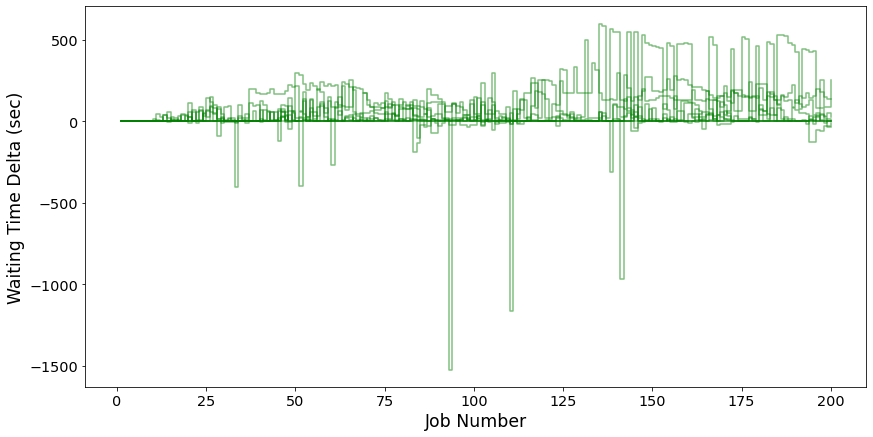

In [28]:
fig, ax = plt.subplots(figsize=[14,7])
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

runs=range(0,10)

for j in runs:
    st_acct = dic_st_bf_sacct[j].loc[:, ['JobName', 'wait_time']].copy()
    st_acct['job_name'] = st_acct['JobName'].astype(int)
    st_acct['RunType'] = 'slurmtrain'
    st_acct['SchedType'] = 'FIFO'

    sala_jobs = dic_sala_bf_dfjobs[j].loc[:, ['job_name', 'wait_time']].copy()
    sala_jobs['job_name'] = sala_jobs['job_name'].astype(int)
    sala_jobs['RunType'] = 'salabim'
    sala_jobs['SchedType'] = 'FIFO'

    compare_wait = pd.merge(left=sala_jobs, 
                            right=st_acct, 
                            how="inner",
                            on="job_name",
                            suffixes = ("_sala", "_st")
                            )
    
    compare_wait['Job Number'] = compare_wait.job_name - 1000 + 1

    
    # Plot
    ax.step(compare_wait['Job Number'], 
        compare_wait.wait_time_st - compare_wait.wait_time_sala,
        where='post',
        label = f"Jitter: SlurmTrain - SimPE",
        c='g',
        alpha=.5,
        )
    
# ax.legend()
ax.set_xlabel('Job Number')
# ax.set_ylabel(r'PE Available / Max PE')
ax.set_ylabel('Waiting Time Delta (sec)')

myrun_models = f"{myrun_type}_wait_jitter_plot"
pltpath = f'{save_image_path}/{myrun_shortname}_{myrun_models}.png'

plt.savefig(pltpath, facecolor='w', transparent=False, dpi=300)

plt.show()

In [29]:
# WHAT YOU WANT TO SHOW IS THE IMPROVEMENT ABOBE THE FIFO VERSION!!!!

In [30]:
###

### Jitter Wait Delta: histogram

In [31]:
j = 0
st_acct = dic_st_bf_sacct[j].loc[:, ['JobName', 'pe_req', 'Account', 'wait_time']].copy()
st_acct = st_acct.rename(columns={'pe_req':'job_pe_req'})
st_acct['priority'] = np.select([st_acct.Account == "training", st_acct.Account == "crucial"], ["Low", "High"])
st_acct['job_name'] = st_acct['JobName'].astype(int)
st_acct['RunType'] = 'slurmtrain'
st_acct['SchedType'] = 'BF'

st_acct

,JobName,job_pe_req,Account,wait_time,priority,job_name,RunType,SchedType
0,1000,1,training,1.0,Low,1000,slurmtrain,BF
1,1001,1,training,0.0,Low,1001,slurmtrain,BF
2,1002,3,training,0.0,Low,1002,slurmtrain,BF
3,1003,1,training,0.0,Low,1003,slurmtrain,BF
4,1004,3,training,0.0,Low,1004,slurmtrain,BF
...,...,...,...,...,...,...,...,...
195,1195,3,training,398.0,Low,1195,slurmtrain,BF
196,1196,1,training,253.0,Low,1196,slurmtrain,BF
197,1197,3,training,250.0,Low,1197,slurmtrain,BF
198,1198,8,training,257.0,Low,1198,slurmtrain,BF


In [32]:
runs=range(0,10)

list_compare_wait = []

for j in runs:
    st_acct = dic_st_bf_sacct[j].loc[:, ['JobName', 'pe_req', 'Account', 'wait_time']].copy()
    st_acct = st_acct.rename(columns={'pe_req':'job_pe_req'})
    st_acct['priority'] = np.select([st_acct.Account == "training", st_acct.Account == "crucial"], ["Low", "High"])
    st_acct['job_name'] = st_acct['JobName'].astype(int)
    st_acct = st_acct.loc[:, ['job_name', 'job_pe_req', 'priority', 'wait_time']].copy()

    sala_jobs = dic_sala_bf_dfjobs[j].loc[:, ['job_name', 'job_pe_req', "job_prio", 'wait_time']].copy()
    sala_jobs['priority'] = np.select([sala_jobs.job_prio == 1, sala_jobs.job_prio==10], ["Low", "High"])
    sala_jobs['job_name'] = sala_jobs['job_name'].astype(int)
    sala_jobs = sala_jobs.loc[:, ['job_name', 'job_pe_req', 'priority', 'wait_time']].copy()
    
    ssim_jobs = dic_ss_bf_sacct[j].loc[:, ['JobName', 'pe_req', 'Account', 'wait_time']].copy()
    ssim_jobs = ssim_jobs.rename(columns={'pe_req':'job_pe_req'})
    ssim_jobs['priority'] = np.select([ssim_jobs.Account == "training", ssim_jobs.Account == "crucial"], ["Low", "High"])
    ssim_jobs['job_name'] = ssim_jobs['JobName'].astype(int)
    ssim_jobs = ssim_jobs.loc[:, ['job_name', 'job_pe_req', 'priority', 'wait_time']].copy()

    # Combine
    
    compare_wait = pd.merge(left=sala_jobs, 
                        right=st_acct, 
                        how="inner",
                        on=["job_name", "job_pe_req", "priority"],
                        suffixes = ("_sala", "_st")
                        )
    
    compare_wait = pd.merge(left=compare_wait, 
                            right=ssim_jobs, 
                            how="left",
                            on=["job_name", "job_pe_req", "priority"],
                            suffixes = ("", "_ssim")
                            )
    
    compare_wait = compare_wait.rename(columns={"wait_time": "wait_time_ssim"})
    
    # 
    compare_wait['SchedType'] = 'BF'
    compare_wait['Job Number'] = compare_wait.job_name - 1000 + 1
    compare_wait['run_num'] = j+1
    
    compare_wait['delta_wait'] = compare_wait.wait_time_st - compare_wait.wait_time_sala
  
    list_compare_wait.append(compare_wait)

#     # Plot
#     ax.step(compare_wait['Job Number'], 
#         compare_wait.wait_time_st - compare_wait.wait_time_sala,
#         where='post',
#         label = f"Jitter: SlurmTrain - SimPE",
#         c='g',
#         alpha=.5,
#         )

compare_wait_all = (pd.concat(list_compare_wait)
                    .reset_index(drop=True)
                    .loc[:, ["run_num", "SchedType", "Job Number", "job_name", 
                             "job_pe_req","priority",
                             "wait_time_sala", "wait_time_ssim", "wait_time_st", "delta_wait"]]
                   )

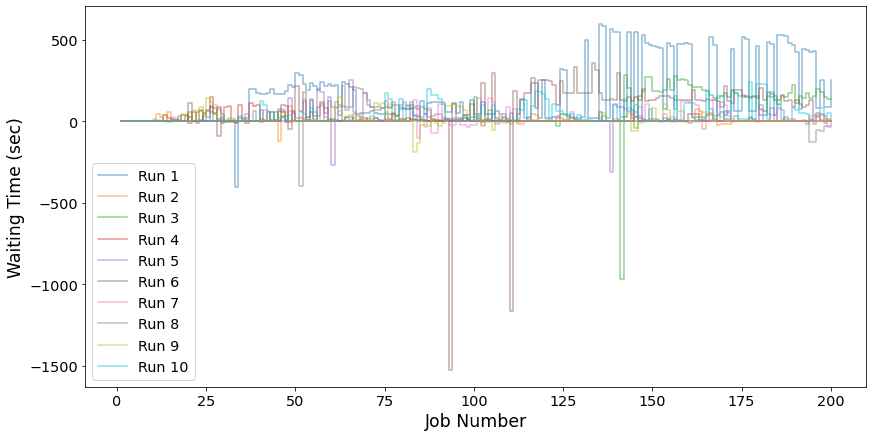

In [33]:
fig, ax = plt.subplots(figsize=[14,7])
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

runs=range(0,10)

compare_wait_all=compare_wait_all.set_index('run_num')

for run in compare_wait_all.index.unique():
    # Plot
    
    ax.step(compare_wait_all.loc[run]['Job Number'], 
        compare_wait_all.loc[run].delta_wait,
        where='post',
        label = f"Run {run}",
#         c='g',
        alpha=.5,
        )

compare_wait_all=compare_wait_all.reset_index()
    
ax.legend()
ax.set_xlabel('Job Number')
# ax.set_ylabel(r'PE Available / Max PE')
ax.set_ylabel('Waiting Time (sec)')

myrun_models = f"{myrun_type}_wait_jitter_plot_colour"
pltpath = f'{save_image_path}/debug/{myrun_shortname}_{myrun_models}.png'

# plt.savefig(pltpath, facecolor='w', transparent=False)

plt.show()

### Tables

#### Wait Table All

In [34]:
wait_table_all = (compare_wait_all
#  .query("run_num == 1")`
 .loc[:, ['run_num', 'job_name', 'wait_time_sala', 'wait_time_ssim', 'wait_time_st', 'delta_wait']]
 .groupby('run_num')
 .agg({'job_name' : ['count'],
       'wait_time_sala' : ['mean'],
       'wait_time_ssim' : ['mean'],
       'wait_time_st' : ['mean']}
     )          
 .reset_index(drop=False)
)

wait_table_all["ratio_sala"] = wait_table_all.wait_time_sala / wait_table_all.wait_time_st
wait_table_all["ratio_ssim"] = wait_table_all.wait_time_ssim / wait_table_all.wait_time_st

# wait_table_all.columns = wait_table_all.columns.droplevel(1)

# wait_table_all = wait_table_all.rename(columns={'run_num':'Run Number'})

# wait_table_all.set_index('Run Number', inplace=True)

# mycolumns = [('', 'Run Number'),
#              ('', 'Job Count'), 
#              ('Waiting Time', 'SlurmTrain'),
#              ('Waiting Time', 'SimPE'),
#              ('Waiting Time', 'Delta')]

# wait_table_all.columns = pd.MultiIndex.from_tuples(mycolumns)

wait_table_all

,run_num,job_name,wait_time_sala,wait_time_ssim,wait_time_st,ratio_sala,ratio_ssim
,,count,mean,mean,mean,,
0,1,200,130.270,258.775,284.575,0.457770,0.909338
1,2,200,12.620,16.810,17.425,0.724247,0.964706
2,3,200,25.585,83.345,77.025,0.332165,1.082051
3,4,200,19.450,29.115,29.780,0.653123,0.977670
4,5,200,20.905,39.760,40.995,0.509940,0.969874
5,6,200,69.800,148.045,136.250,0.512294,1.086569
6,7,200,67.415,89.435,83.180,0.810471,1.075198
7,8,200,29.630,47.130,48.815,0.606986,0.965482
8,9,200,41.365,54.635,54.220,0.762910,1.007654


In [35]:
table_name = f"{myrun_type}_wait_table_all.tex"
table_path = Path(f'{save_image_path}/tables/{table_name}')

print(f"LATEX OUTPUT: {table_path}")
print(f"LATEX INCLUDE: {table_name}")
# print(f"LATEX INCLUDE: \input{{{str(table_path.relative_to('images'))}}}")
print("")

latex_table = (wait_table_all
    .loc[:, ["run_num", "wait_time_sala", "wait_time_ssim", "wait_time_st", "ratio_sala", "ratio_ssim"]]
    .droplevel(1, axis=1)
    .to_latex(index = False,
            column_format = 'cccccc',
            header=["Run Number", 
                    r"$\overline{W}^{(bf)}_{PE}$",
                    r"$\overline{W}^{(bf)}_{SS}$",
                    r"$\overline{W}^{(bf)}_{ST}$",
                    r"$\overline{W}^{(bf)}_{PE} / \overline{W}^{(bf)}_{ST}$",
                    r"$\overline{W}^{(bf)}_{SS} / \overline{W}^{(bf)}_{ST}$",
                   ],
            float_format="%.2f",
            escape = False)
)

# Modifications to the latex table code:

# latex_list = latex_table.splitlines()

# new_header_list = [
# r"\begin{tabular}{lrrrr}",
# r"\toprule",
# r"& & \multicolumn{3}{c}{Waiting Time (sec)} \\ \cline{3-5}" ,
# r"Run Number & Count & SlurmTrain & SimPE & Delta \\",
# r"\midrule"
# ]

# latex_new_list = new_header_list + latex_list[2:]

# # # latex_list.insert(3, r'\cmidrule(lr){3-5} \\')

# # # for i,line in enumerate(latex_list): 
# # #     if line.find(r"\begin{table}") >= 0: 
# # #         latex_list[i] = r"\begin{table}[!ht]"

# latex_new_table = "\n".join(latex_new_list)
# latex_new_table = latex_table
# print(latex_new_table)
      
print(latex_table)
    
# # Write Output
with open(table_path, 'w') as f:
    f.write(latex_table)

LATEX OUTPUT: images/results/tables/bfrun_wait_table_all.tex
LATEX INCLUDE: bfrun_wait_table_all.tex

\begin{tabular}{cccccc}
\toprule
Run Number & $\overline{W}^{(bf)}_{PE}$ & $\overline{W}^{(bf)}_{SS}$ & $\overline{W}^{(bf)}_{ST}$ & $\overline{W}^{(bf)}_{PE} / \overline{W}^{(bf)}_{ST}$ & $\overline{W}^{(bf)}_{SS} / \overline{W}^{(bf)}_{ST}$ \\
\midrule
         1 &                     130.27 &                     258.77 &                     284.57 &                                               0.46 &                                               0.91 \\
         2 &                      12.62 &                      16.81 &                      17.43 &                                               0.72 &                                               0.96 \\
         3 &                      25.59 &                      83.34 &                      77.03 &                                               0.33 &                                               1.08 \\
         4 &          

#### Wait Table Metrics

In [36]:
wait_table_all_metrics

NameError: name 'wait_table_all_metrics' is not defined

In [ ]:
# Waiting time all jobs - metric table

wait_table_all_metrics = wait_table_all.copy()

wait_table_all_metrics.columns = wait_table_all_metrics.columns.droplevel(1)

# metrics = ['min', 'max',  'std', 'mean']
# metric_names = ['min', 'max', '$s_{dev}$', 'average']

wait_table_all_metrics = (wait_table_all_metrics
                          .drop(columns=['run_num', 'job_name'])
                          .agg(metrics)
                          .reset_index()
                          .rename(columns={'index':'metric'})
                          .assign(metric_name = metric_names)
                         )

wait_table_all_metrics

# wait_table_all.columns

In [ ]:
table_name = f"{myrun_type}_wait_table_all_metrics.tex"
table_path = Path(f'{save_image_path}/tables/{table_name}')

print(f"LATEX OUTPUT: {table_path}")
print(f"LATEX INCLUDE: {table_name}")
# print(f"LATEX INCLUDE: \input{{{str(table_path.relative_to('images'))}}}")
print("")

latex_table = (wait_table_all_metrics
    .loc[:, ["metric_name", "wait_time_sala", "wait_time_ssim", "wait_time_st", "ratio_sala", "ratio_ssim"
            ]]
    .to_latex(index = False,
            column_format = 'lccccc',
            header=["Metric", 
                    r"$\overline{W}^{(bf)}_{PE}$",
                    r"$\overline{W}^{(bf)}_{SS}$",
                    r"$\overline{W}^{(bf)}_{ST}$",
                    r"$\overline{W}^{(bf)}_{PE} / \overline{W}^{(bf)}_{ST}$",
                    r"$\overline{W}^{(bf)}_{SS} / \overline{W}^{(bf)}_{ST}$"
                   ],
            float_format="%.2f",
            escape = False)
)

# # Modifications to the latex table code:

# latex_list = latex_table.splitlines()

# new_header_list = [
# r"\begin{tabular}{lrrrr}",
# r"\toprule",
# r"& & \multicolumn{3}{c}{Average Waiting Time (sec)} \\ \cline{3-5}" ,
# r"Run Number & Count & SlurmTrain & SimPE & Delta \\",
# r"\midrule"
# ]

# latex_new_list = new_header_list + latex_list[2:]

# # # latex_list.insert(3, r'\cmidrule(lr){3-5} \\')

# # # for i,line in enumerate(latex_list): 
# # #     if line.find(r"\begin{table}") >= 0: 
# # #         latex_list[i] = r"\begin{table}[!ht]"

# latex_new_table = "\n".join(latex_new_list)
    
# print(latex_new_table)

print(latex_table)

# # Write Output
with open(table_path, 'w') as f:
    f.write(latex_table)

#### Backfill Count Table

In [ ]:
#BACKFILL COUNT TABLE -  WIP!!!!

print("## BACKFILL COUNTS")
print("")

(df_wait_combo
 .loc[(df_wait_combo.SchedType == "BF"), ['RunNum', 'RunType', 'Total_run_backfills']]
 .drop_duplicates()
 .pivot(index='RunNum', columns='RunType', values='Total_run_backfills'))

#### Wait Time per Job Type

In [ ]:
# Waiting Time per job

wait_table_jobtype_all = (compare_wait_all
#  .query("run_num == 1")
 .loc[:, ['run_num', 'job_pe_req', "priority", 'job_name', 'wait_time_sala', 'wait_time_ssim', 'wait_time_st', 'delta_wait']]
 .assign(str_job_pe_req = lambda x: x.job_pe_req.astype(str))
 .groupby(['run_num','str_job_pe_req', "priority"])
 .agg({'job_name' : ['count'],
       'wait_time_sala' : ['mean'],
       'wait_time_ssim' : ['mean'],
       'wait_time_st' : ['mean']})
 .reset_index(drop=False)                        
)

wait_table_jobtype_all.columns = wait_table_jobtype_all.columns.droplevel(1)
wait_table_jobtype_all.rename(columns={'job_name':'job_count',
                                       'str_job_pe_req' : 'job_pe_req'}, inplace=True)

wait_table_jobtype_all["job_type"] = wait_table_jobtype_all.job_pe_req + " PE" # + wait_table_jobtype_all.priority + " Priority"

wait_table_jobtype_all.head()

In [ ]:
# # # Create a scatter plot
# fig, ax = plt.subplots(111, figsize=(10, 6))  # Adjust the figure size as needed

# # p = plt.

# plt.scatter(wait_table_jobtype_all.)

# plt.show()

# df = wait_table_jobtype_all

# # Choose 'ratio_sala' or 'ratio_ssim' as the y-axis variable
# y_axis_variable = 'ratio_sala'  # Change to 'ratio_ssim' if needed

# # Create a colormap for coloring points based on job_pe_req values
# colormap = plt.cm.get_cmap('viridis')  # You can choose a different colormap if you prefer

# # Scatter plot with colors based on job_pe_req
# sc = plt.scatter(df['wait_time_st'], df[y_axis_variable], c=df['job_pe_req'], cmap=colormap, alpha=0.7)

# # Add labels and a colorbar
# plt.xlabel('Wait Time (wait_time_st)')
# plt.ylabel(y_axis_variable)
# plt.title('Scatter Plot of wait_time_st vs. ' + y_axis_variable)
# plt.colorbar(sc, label='job_pe_req')

In [ ]:
batch_count = wait_table_jobtype_all.run_num.max()

wait_table_jobtype_table = (wait_table_jobtype_all
                            .groupby(["priority", "job_pe_req", "job_type"])
                            .agg({'run_num' : ['nunique'],
                                  'job_count' : ['sum'],
                                  'wait_time_sala' :['mean'],
                                  'wait_time_ssim' :['mean'],
                                  'wait_time_st' :['mean']})
                            .sort_index(ascending=[False, True])
                            .droplevel(1,axis=1)
                            .reset_index(drop=False)
                            .assign(ratio_sala = lambda x: x.wait_time_sala / x.wait_time_st)
                            .assign(ratio_ssim = lambda x: x.wait_time_ssim / x.wait_time_st)
                            .assign(jobs_per_batch = lambda x: x.job_count / batch_count)
                            .drop(columns='priority')
)

wait_table_jobtype_table

In [ ]:
table_name = f"{myrun_type}_wait_table_jobtypes.tex"
table_path = Path(f'{save_image_path}/tables/{table_name}')

print(f"LATEX OUTPUT: {table_path}")
print(f"LATEX INCLUDE: {table_name}")
print("")

latex_table = (wait_table_jobtype_table
               .loc[:, ['job_type', 'jobs_per_batch', 'wait_time_sala', 'wait_time_ssim', 'wait_time_st', 
                        'ratio_sala', 'ratio_ssim']]
               .to_latex(
    index=False,
    column_format='ccccccc',
    header=["Job Type", 
            "Average Jobs Per Batch",
            r"$\mu_{\overline{W}^{(bf)}_{PE}}$",
            r"$\mu_{\overline{W}^{(bf)}_{SS}}$",
            r"$\mu_{\overline{W}^{(bf)}_{ST}}$",
            r"$\mu_{\overline{W}^{(bf)}_{PE}} / \mu_{\overline{W}^{(bf)}_{ST}}$",
            r"$\mu_{\overline{W}^{(bf)}_{SS}} / \mu_{\overline{W}^{(bf)}_{ST}}$"
           ],
    float_format="%.2f",
    escape = False) 
)
    
print(latex_table)
    
# # Write Output
with open(table_path, 'w') as f:
    f.write(latex_table)


### OLD WAIT TABLE: SALA & ST 

In [ ]:
# wait_table_all = (compare_wait_all
# #  .query("run_num == 1")`
#  .loc[:, ['run_num', 'job_name', 'wait_time_sala',  'wait_time_st', 'delta_wait']]
#  .groupby('run_num')
#  .agg({'job_name' : ['count'],
#        'wait_time_sala' : ['mean'],
#        'wait_time_st' : ['mean']}
#      )          
#  .reset_index(drop=False)
# )

# wait_table_all["ratio"] = wait_table_all.wait_time_sala / wait_table_all.wait_time_st

# # wait_table_all.columns = wait_table_all.columns.droplevel(1)

# # wait_table_all = wait_table_all.rename(columns={'run_num':'Run Number'})

# # wait_table_all.set_index('Run Number', inplace=True)

# # mycolumns = [('', 'Run Number'),
# #              ('', 'Job Count'), 
# #              ('Waiting Time', 'SlurmTrain'),
# #              ('Waiting Time', 'SimPE'),
# #              ('Waiting Time', 'Delta')]

# # wait_table_all.columns = pd.MultiIndex.from_tuples(mycolumns)

# wait_table_all

In [ ]:
# table_name = f"{myrun_type}_wait_table_all.tex"
# table_path = Path(f'{save_image_path}/tables/{table_name}')

# print(f"LATEX OUTPUT: {table_path}")
# print(f"LATEX INCLUDE: {table_name}")
# # print(f"LATEX INCLUDE: \input{{{str(table_path.relative_to('images'))}}}")
# print("")

# latex_table = (wait_table_all
#     .loc[:, ["run_num", "wait_time_sala", "wait_time_st", "ratio"]]
#     .droplevel(1, axis=1)
#     .to_latex(index = False,
#             column_format = 'cccc',
#             header=["Run Number", 
#                     r"$\mu_{\overline{W}_{PE}}$",
#                     r"$\mu_{\overline{W}_{ST}}$",
#                     r"$\mu_{\overline{W}_{PE}} / \mu_{\overline{W}_{ST}}$",
#                    ],
#             float_format="%.2f",
#             escape = False)
# )

# # Modifications to the latex table code:

# # latex_list = latex_table.splitlines()

# # new_header_list = [
# # r"\begin{tabular}{lrrrr}",
# # r"\toprule",
# # r"& & \multicolumn{3}{c}{Waiting Time (sec)} \\ \cline{3-5}" ,
# # r"Run Number & Count & SlurmTrain & SimPE & Delta \\",
# # r"\midrule"
# # ]

# # latex_new_list = new_header_list + latex_list[2:]

# # # # latex_list.insert(3, r'\cmidrule(lr){3-5} \\')

# # # # for i,line in enumerate(latex_list): 
# # # #     if line.find(r"\begin{table}") >= 0: 
# # # #         latex_list[i] = r"\begin{table}[!ht]"

# # latex_new_table = "\n".join(latex_new_list)
# # latex_new_table = latex_table
# # print(latex_new_table)
      
# print(latex_table)
    
# # # Write Output
# with open(table_path, 'w') as f:
#     f.write(latex_table)

In [ ]:
# #BACKFILL COUNT TABLE -  WIP!!!!

# print("## BACKFILL COUNTS")
# print("")

# (df_wait_combo
#  .loc[(df_wait_combo.SchedType == "BF"), ['RunNum', 'RunType', 'Total_run_backfills']]
#  .drop_duplicates()
#  .pivot(index='RunNum', columns='RunType', values='Total_run_backfills'))

In [ ]:
# # Waiting Time per job

# wait_table_jobtype_all = (compare_wait_all
# #  .query("run_num == 1")
#  .loc[:, ['run_num', 'job_pe_req', "priority", 'job_name', 'wait_time_sala', 'wait_time_st', 'delta_wait']]
#  .assign(str_job_pe_req = lambda x: x.job_pe_req.astype(str))
#  .groupby(['run_num','str_job_pe_req', "priority"])
#  .agg({'job_name' : ['count'],
#        'wait_time_sala' : ['mean'],
#        'wait_time_st' : ['mean']})
#  .reset_index(drop=False)                        
# )

# wait_table_jobtype_all.columns = wait_table_jobtype_all.columns.droplevel(1)
# wait_table_jobtype_all.rename(columns={'job_name':'job_count',
#                                        'str_job_pe_req' : 'job_pe_req'}, inplace=True)

# wait_table_jobtype_all["job_type"] = wait_table_jobtype_all.job_pe_req + " PE" # + wait_table_jobtype_all.priority + " Priority"

# wait_table_jobtype_all.head()

In [ ]:
# batch_count = wait_table_jobtype_all.run_num.max()

# wait_table_jobtype_table = (wait_table_jobtype_all
#                             .groupby(["priority", "job_pe_req", "job_type"])
#                             .agg({'run_num' : ['nunique'],
#                                   'job_count' : ['sum'],
#                                   'wait_time_sala' :['mean'],
#                                   'wait_time_st' :['mean']})
#                             .sort_index(ascending=[False, True])
#                             .droplevel(1,axis=1)
#                             .reset_index(drop=False)
#                             .assign(ratio = lambda x: x.wait_time_sala / x.wait_time_st)
#                             .assign(jobs_per_batch = lambda x: x.job_count / batch_count)
#                             .drop(columns='priority')
# )

# wait_table_jobtype_table

In [ ]:
# table_name = f"{myrun_type}_wait_table_jobtypes.tex"
# table_path = Path(f'{save_image_path}/tables/{table_name}')

# print(f"LATEX OUTPUT: {table_path}")
# print(f"LATEX INCLUDE: {table_name}")
# print("")

# latex_table = (wait_table_jobtype_table
#                .loc[:, ['job_type', 'jobs_per_batch', 'wait_time_sala', 'wait_time_st', 'ratio']]
#                .to_latex(
#     index=False,
#     column_format='ccccc',
#     header=["Job Type", 
#             "Average Jobs Per Batch",
#             r"$\mu_{\overline{W}_{PE}}$",
#             r"$\mu_{\overline{W}_{ST}}$",
#             r"$\mu_{\overline{W}_{PE}} / \mu_{\overline{W}_{ST}}$"
#            ],
#     float_format="%.2f",
#     escape = False) 
# )
    
# print(latex_table)
    
# # # Write Output
# with open(table_path, 'w') as f:
#     f.write(latex_table)


### OLD Waittime Job Type Table

In [ ]:
# # Waiting Time per job 

# wait_table_jobtype_all = (compare_wait_all
# #  .query("run_num == 1")
#  .loc[:, ['run_num', 'job_pe_req', "priority", 'job_name', 'wait_time_st', 'wait_time_sala', 'delta_wait']]
#  .assign(str_job_pe_req = lambda x: x.job_pe_req.astype(str))
#  .groupby(['run_num','str_job_pe_req', "priority"])
#  .agg({'job_name' : ['count'],
#        'wait_time_sala' : ['mean'],
#        'wait_time_st' : ['mean']})
#  .reset_index(drop=False)                        
# )

# wait_table_jobtype_all["delta"] = wait_table_jobtype_all.wait_time_st - wait_table_jobtype_all.wait_time_sala

# wait_table_jobtype_all.columns = wait_table_jobtype_all.columns.droplevel(1)
# wait_table_jobtype_all.rename(columns={'job_name':'job_count',
#                                        'str_job_pe_req' : 'job_pe_req'}, inplace=True)

# wait_table_jobtype_all["job_type"] = wait_table_jobtype_all.job_pe_req + " PE" # + wait_table_jobtype_all.priority + " Priority"

# wait_table_jobtype_all.head()

In [ ]:
# wait_table_jobtype_table0 = (wait_table_jobtype_all
#                             .groupby(["priority", "job_pe_req", "job_type"])
#                             .agg({'run_num' : ['nunique'],
#                                   'job_count' : ['sum'],
#                                   'wait_time_st' :['mean'],
#                                   'wait_time_sala' :['mean'],
#                                   'delta': ['mean', 'std']})
#                             .sort_index(ascending=[False, True, True])
#                            )

# wait_table_jobtype_table0.reset_index(inplace=True)
# wait_table_jobtype_table0.drop(columns=["priority", "job_pe_req"], inplace=True, level = 0)
# wait_table_jobtype_table0.set_index("job_type", inplace=True)

# wait_table_jobtype_table0

In [ ]:
# # Combined

# wait_all_jobs_row = (wait_table_jobtype_all
#                      .loc[(wait_table_jobtype_all.job_type != "8 PE"),:]
#                      .assign(job_type = '1 PE or 3 PE')
#                      .groupby(['job_type'])
#                      .agg({'run_num' : ['nunique'],
#                            'job_count' : ['sum'],
#                            'wait_time_st' :['mean'],
#                            'wait_time_sala' :['mean'],
#                            'delta': ['mean', 'std']})
#                )

# wait_all_jobs_row

In [ ]:
# wait_table_jobtype_table = pd.concat([wait_table_jobtype_table0, wait_all_jobs_row], axis=0)

# # Job count sum -> Job count per batch
# batch_count = np.median(wait_table_jobtype_table['run_num']['nunique'])
# wait_table_jobtype_table.loc[:, ('job_count','sum')] = wait_table_jobtype_table.loc[:, ('job_count','sum')] / batch_count

# # # Drop Job Batch count column
# wait_table_jobtype_table.drop(columns=['run_num'], level=0, inplace=True)

# # Drop Indexes
# wait_table_jobtype_table.reset_index(drop=False, inplace=True)

# # Show Table
# wait_table_jobtype_table

In [ ]:
# # Rounding
# wait_table_jobtype_table.wait_time_st = wait_table_jobtype_table.wait_time_st.round(2)
# wait_table_jobtype_table.wait_time_sala = wait_table_jobtype_table.wait_time_sala.round(2)
# wait_table_jobtype_table.delta = wait_table_jobtype_table.delta.round(2)


# wait_table_jobtype_table

In [ ]:
# table_name = f"{myrun_type}_wait_table_jobtypes.tex"
# table_path = Path(f'{save_image_path}/tables/{table_name}')

# print(f"LATEX OUTPUT: {table_path}")
# print(f"LATEX INCLUDE: {table_name}")
# print("")

# latex_table = (wait_table_jobtype_table
#                .droplevel(1, axis=1)
#                .to_latex(
#     index=False,
#     escape=False,
#     column_format='lcccccc',
#     header=["Job Type", 
#             "Average Jobs Per Batch",
#             r"$\mu_{\overline{W}_{ST}}$",
#             r"$\mu_{\overline{W}_{PE}}$",
#             r"$\mu_{\overline{W_{ST, j}-W_{PE, j}}}$",
#             r"$\sigma_{\overline{W_{ST, j}-W_{PE, j}}}$"
#             #r"$\mu_{\overline{\Delta W_j}}$",
#             #r"$\sigma_{\overline{\Delta W_j}}$"
#            ])
# )
    
# print(latex_table)
    
# # # Write Output
# with open(table_path, 'w') as f:
#     f.write(latex_table)

### Histograms OLD

In [ ]:
wait_table_jobtype_all['ratio_sala'] = wait_table_jobtype_all.wait_time_sala / wait_table_jobtype_all.wait_time_st
wait_table_jobtype_all['ratio_ssim'] = wait_table_jobtype_all.wait_time_ssim / wait_table_jobtype_all.wait_time_st

wait_table_jobtype_all.sort_values('job_pe_req')

In [ ]:
# ?np.linspace(0.0, 10, 10)

In [ ]:
# ?np.linspace(0.0, 10, retstep=0.1)

In [ ]:
wait_table_jobtype_all.loc[wait_table_jobtype_all.job_type!='8 PE',:].sort_values('job_type')

#### Ratio / Delta Histograms

In [ ]:
wait_table_jt_plot = wait_table_jobtype_all.loc[wait_table_jobtype_all.job_type!='8 PE',:].copy()

wait_table_jt_plot["delta_st_sala"] = wait_table_jt_plot.wait_time_st - wait_table_jt_plot.wait_time_sala

pe_list = wait_table_jt_plot.job_pe_req.unique().tolist()

x = wait_table_jt_plot.delta_st_sala.values
counts, bins = np.histogram(x)

fig, ax = plt.subplots(figsize=(14,7))

for pe in pe_list:
    x = wait_table_jt_plot.loc[wait_table_jt_plot.job_pe_req==pe,:].delta_st_sala.values

    plt.hist(x, bins, alpha=0.5, label=f'PE = {pe}')

plt.xlabel('Delta ($\overline{W}_{ST} - \overline{W}_{PE})$')
plt.ylabel('count')
plt.legend(loc='upper center')

plt.title(f"{myrun_type}")

myrun_models = f"{myrun_type}_histo_jobtype_delta_sala"
pltpath = f'{save_image_path}/debug/{myrun_type}_{myrun_models}.png'

plt.savefig(pltpath, facecolor='w', transparent=False)

plt.show()

# plt.show()

# counts, bins = np.histogram(x)
# plt.bar(bins[:-1], counts, width=(bins[1]-bins[0]))
# hist(x, bins='knuth', density=True)

# # n, bins, patches = hist(x, bins="knuth", density=True) # For continues x
# # showbins = np.round(bins, 1)

# # n, bins, patches = hist(x, density=True) # For discrete x
# # showbins = bins.astype(int)

# # # centre labels
# # n_bins =len(bins)-1
# # ticks = [(patch._x0 + patch._x1)/2 for patch in patches]
# # ticklabels = [showbins[i] for i in range(n_bins)]
# # plt.xticks(ticks, ticklabels)

# plt.title(f"Run {j+1}")
# plt.show()

In [ ]:
wait_table_jt_plot = wait_table_jobtype_all.loc[wait_table_jobtype_all.job_type!='8 PE',:].copy()

pe_list = wait_table_jt_plot.job_pe_req.unique().tolist()

x = wait_table_jt_plot.ratio_sala.values
counts, bins = np.histogram(x)

fig, ax = plt.subplots(figsize=(14,7))

for pe in pe_list:
    x = wait_table_jt_plot.loc[wait_table_jt_plot.job_pe_req==pe,:].ratio_sala.values

    max_value = wait_table_jt_plot.ratio_sala.max()

    plt.hist(x, bins, alpha=0.5, label=f'PE = {pe}')

plt.xlabel('Ratio ($\overline{W}_{PE} / \overline{W}_{ST}$)')
plt.ylabel('count')
plt.legend(loc='upper center')

plt.title(f"{myrun_type}")

myrun_models = f"{myrun_type}_histo_jobtype_ratio_sala"
pltpath = f'{save_image_path}/debug/{myrun_type}_{myrun_models}.png'

plt.savefig(pltpath, facecolor='w', transparent=False)

plt.show()

# plt.show()

# counts, bins = np.histogram(x)
# plt.bar(bins[:-1], counts, width=(bins[1]-bins[0]))
# hist(x, bins='knuth', density=True)

# # n, bins, patches = hist(x, bins="knuth", density=True) # For continues x
# # showbins = np.round(bins, 1)

# # n, bins, patches = hist(x, density=True) # For discrete x
# # showbins = bins.astype(int)

# # # centre labels
# # n_bins =len(bins)-1
# # ticks = [(patch._x0 + patch._x1)/2 for patch in patches]
# # ticklabels = [showbins[i] for i in range(n_bins)]
# # plt.xticks(ticks, ticklabels)

# plt.title(f"Run {j+1}")
# plt.show()

In [ ]:
wait_table_jt_plot = wait_table_jobtype_all.loc[wait_table_jobtype_all.job_type!='8 PE',:].copy()

wait_table_jt_plot["delta_st_ssim"] = wait_table_jt_plot.wait_time_st - wait_table_jt_plot.wait_time_ssim

pe_list = wait_table_jt_plot.job_pe_req.unique().tolist()

x = wait_table_jt_plot.delta_st_ssim.values
counts, bins = np.histogram(x)

fig, ax = plt.subplots(figsize=(14,7))

for pe in pe_list:
    x = wait_table_jt_plot.loc[wait_table_jt_plot.job_pe_req==pe,:].delta_st_ssim.values

    plt.hist(x, bins, alpha=0.5, label=f'PE = {pe}')

plt.xlabel('Delta ($\overline{W}_{ST} - \overline{W}_{SS})$')
plt.ylabel('count')
plt.legend(loc='upper center')

plt.title(f"{myrun_type}")

myrun_models = f"{myrun_type}_histo_jobtype_delta_ssim"
pltpath = f'{save_image_path}/debug/{myrun_type}_{myrun_models}.png'

plt.savefig(pltpath, facecolor='w', transparent=False)

plt.show()

# plt.show()

# counts, bins = np.histogram(x)
# plt.bar(bins[:-1], counts, width=(bins[1]-bins[0]))
# hist(x, bins='knuth', density=True)

# # n, bins, patches = hist(x, bins="knuth", density=True) # For continues x
# # showbins = np.round(bins, 1)

# # n, bins, patches = hist(x, density=True) # For discrete x
# # showbins = bins.astype(int)

# # # centre labels
# # n_bins =len(bins)-1
# # ticks = [(patch._x0 + patch._x1)/2 for patch in patches]
# # ticklabels = [showbins[i] for i in range(n_bins)]
# # plt.xticks(ticks, ticklabels)

# plt.title(f"Run {j+1}")
# plt.show()

In [ ]:
wait_table_jt_plot = wait_table_jobtype_all.loc[wait_table_jobtype_all.job_type!='8 PE',:].copy()

pe_list = wait_table_jt_plot.job_pe_req.unique().tolist()

x = wait_table_jt_plot.ratio_ssim.values
counts, bins = np.histogram(x)

fig, ax = plt.subplots(figsize=(14,7))

for pe in pe_list:
    x = wait_table_jt_plot.loc[wait_table_jt_plot.job_pe_req==pe,:].ratio_ssim.values

    max_value = wait_table_jt_plot.ratio_sala.max()

    plt.hist(x, bins, alpha=0.5, label=f'PE = {pe}')

plt.xlabel('Ratio ($\overline{W}_{SS} / \overline{W}_{ST}$)')
plt.ylabel('count')
plt.legend(loc='upper center')

plt.title(f"{myrun_type}")

myrun_models = f"{myrun_type}_histo_jobtype_ratio_ssim"
pltpath = f'{save_image_path}/debug/{myrun_type}_{myrun_models}.png'

plt.savefig(pltpath, facecolor='w', transparent=False)

plt.show()

# plt.show()

# counts, bins = np.histogram(x)
# plt.bar(bins[:-1], counts, width=(bins[1]-bins[0]))
# hist(x, bins='knuth', density=True)

# # n, bins, patches = hist(x, bins="knuth", density=True) # For continues x
# # showbins = np.round(bins, 1)

# # n, bins, patches = hist(x, density=True) # For discrete x
# # showbins = bins.astype(int)

# # # centre labels
# # n_bins =len(bins)-1
# # ticks = [(patch._x0 + patch._x1)/2 for patch in patches]
# # ticklabels = [showbins[i] for i in range(n_bins)]
# # plt.xticks(ticks, ticklabels)

# plt.title(f"Run {j+1}")
# plt.show()

In [ ]:
from astropy.visualization import hist
from scipy.stats import norm, t

# Plot histogram
for j in range(10):

    fig, ax = plt.subplots(figsize=[7,7])
    
    x = list_compare_wait[j].delta_wait
    
    # sns.histplot(list_compare_wait[j].delta_wait, stat = 'density')
    n, bins, patches = hist(x, bins='scott', density=True)
#     n, bins, patches = hist(x, bins='freedman', density=True)
#     hist(x, bins="knuth", density=True)
    
    mu, std = norm.fit(x) 

    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x_axis = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x_axis, mu, std)

    plt.plot(x_axis, p, 'k', linewidth=1, label=f"Norm pdf (mu={mu:.2f}, {std:.2f})")
    
    ax.legend()
    
    plt.title(f"{myrun_type}: run {j+1}")
    
    myrun_models = f"{myrun_type}_run{j+1}_wait_jitter_distrib"
    pltpath = f'{save_image_path}/debug/{myrun_shortname}_{myrun_models}.png'

    plt.savefig(pltpath, facecolor='w', transparent=False)
    
    plt.show()

In [ ]:
# # Plot normalised histogram
# for j in range(10):
#     x = list_compare_wait[j].delta_wait
#     mu_x = np.mean(x)
#     sd_x = np.nanstd(x)
#     x_norm = (x - mu_x) / sd_x
    
# #     sns.histplot(list_compare_wait[j].delta_wait, stat = 'density')
#     n, bins, patches = hist(x_norm, bins='scott')
    
#     plt.title(f"Run {j+1}. Normalised with mu: {mu_x:.2f}, sd: {sd_x: .2f} ")
#     plt.show()

In [ ]:
from scipy.stats import norm

# Plot normalised histogram
combined_x = []
for j in range(10):
    x = list_compare_wait[j].delta_wait
    mu_x = np.mean(x)
    sd_x = np.nanstd(x)
    x_norm = (x - mu_x) / sd_x
    combined_x = x
    
# Plot
fig, ax = plt.subplots(figsize=[7,7])
n, bins, patches = hist(combined_x, bins='scott', density=True, ax = ax)

# Fit a normal distribution to
# the data:
# mean and standard deviation
mu, std = norm.fit(combined_x) 

# Plot the PDF.
xmin, xmax = plt.xlim()
x_axis = np.linspace(xmin, xmax, 100)
p = norm.pdf(x_axis, mu, std)

plt.plot(x_axis, p, 'k', linewidth=1, label=f"Norm pdf (mu={mu:.2f}, {std:.2f})")

ax.legend()

plt.title(f"{myrun_type}: combined delta wait (runs not normalised)")

myrun_models = f"{myrun_type}_run{j+1}_combined_non_norm"
pltpath = f'{save_image_path}/debug/{myrun_shortname}_{myrun_models}.png'

plt.savefig(pltpath, facecolor='w', transparent=False)

plt.show()

This looks quite good ... but I am concerned that the big variance is due to big mismatches between the models. 
Well... I mean we can look at these mismatches ... to see how well they modelled stuff... 
in all likelihood it is just the the effect that stuff can go very wrong. i don't know. 
i don't have to know. it is okay. lets look at the bfsim model too. that's not my model.

In [ ]:
print(f"mean : {np.mean(combined_x):.2f}")
print(f"std: {np.std(combined_x):.2f}")
print(f"median : {np.median(combined_x):.2f}")

In [ ]:
from scipy.stats import norm, t

# Plot normalised histogram
combined_x_norm = []
for j in range(10):
    x = list_compare_wait[j].delta_wait
    mu_x = np.mean(x)
    sd_x = np.nanstd(x)
    x_norm = (x - mu_x) / sd_x
    combined_x_norm = x_norm
    
# Plot
fig, ax = plt.subplots(figsize=[7,7])
n, bins, patches = hist(combined_x_norm, bins='scott', density=True, ax = ax)

# Fit a normal distribution to
# the data:
# mean and standard deviation
mu, std = norm.fit(combined_x_norm) 

# Plot the PDF.
xmin, xmax = plt.xlim()
x_axis = np.linspace(xmin, xmax, 100)
p = norm.pdf(x_axis, mu, std)
plt.plot(x_axis, p, 'k', linewidth=1, label=f"Norm pdf (mu={mu:.2f}, $\sigma$={std:.2f})")

# T distribution
# t_df, t_loc, t_scale = t.fit(combined_x_norm)
# p_t = t.pdf(x_axis, t_df, loc=t_loc, scale=t_scale)
# plt.plot(x_axis, p_t, 'b', linewidth=1, label=f"T pdf (df={t_df:.2f}, loc={t_loc:.2f}, scale={t_scale:.2f}")

ax.legend()

plt.title(f"{myrun_type}: combined delta wait (each run normalised)")

myrun_models = f"{myrun_type}_run{j+1}_combined_norm"
pltpath = f'{save_image_path}/debug/{myrun_shortname}_{myrun_models}.png'

plt.savefig(pltpath, facecolor='w', transparent=False)

plt.show()

In [ ]:
print(f"mean : {np.mean(combined_x_norm)}")
print(f"std: {np.std(combined_x_norm)}")

### OLD CODE: Jitter Wait Delta: histogram

In [ ]:
runs=range(0,10)

list_compare_wait = []

for j in runs:
    st_acct = dic_st_bf_sacct[j].loc[:, ['JobName', 'wait_time']].copy()
    st_acct['job_name'] = st_acct['JobName'].astype(int)
    st_acct['RunType'] = 'slurmtrain'
    st_acct['SchedType'] = 'FIFO'

    sala_jobs = dic_sala_bf_dfjobs[j].loc[:, ['job_name', 'wait_time']].copy()
    sala_jobs['job_name'] = sala_jobs['job_name'].astype(int)
    sala_jobs['RunType'] = 'salabim'
    sala_jobs['SchedType'] = 'FIFO'

    compare_wait = pd.merge(left=sala_jobs, 
                            right=st_acct, 
                            how="inner",
                            on="job_name",
                            suffixes = ("_sala", "_st")
                            )
    
    compare_wait['Job Number'] = compare_wait.job_name - 1000 + 1
    compare_wait['run_num'] = j+1
    
    compare_wait['delta_wait'] = compare_wait.wait_time_st - compare_wait.wait_time_sala
  
    list_compare_wait.append(compare_wait)

#     # Plot
#     ax.step(compare_wait['Job Number'], 
#         compare_wait.wait_time_st - compare_wait.wait_time_sala,
#         where='post',
#         label = f"Jitter: SlurmTrain - SimPE",
#         c='g',
#         alpha=.5,
#         )

compare_wait_all = (pd.concat(list_compare_wait)
                    .reset_index(drop=True)
                    .loc[:, ["run_num", "SchedType_st", "Job Number","job_name", "wait_time_st", "wait_time_sala", "delta_wait"]]
                   )

In [ ]:
# # RECORD OF DIFFERENT WAYS TO PLOT HISTOGRAM

# j = 0
# x = list_compare_wait[j].delta_wait
    
# # sns.histplot(list_compare_wait[j].delta_wait)
# # plt.hist(x, density=True)

# counts, bins = np.histogram(x)
# plt.bar(bins[:-1], counts, width=(bins[1]-bins[0]))
# hist(x, bins='knuth', density=True)

# # n, bins, patches = hist(x, bins="knuth", density=True) # For continues x
# # showbins = np.round(bins, 1)

# # n, bins, patches = hist(x, density=True) # For discrete x
# # showbins = bins.astype(int)

# # # centre labels
# # n_bins =len(bins)-1
# # ticks = [(patch._x0 + patch._x1)/2 for patch in patches]
# # ticklabels = [showbins[i] for i in range(n_bins)]
# # plt.xticks(ticks, ticklabels)

# plt.title(f"Run {j+1}")
# plt.show()

In [ ]:
from astropy.visualization import hist

In [ ]:
# Plot histogram
for j in range(10):

    x = list_compare_wait[j].delta_wait
    
    # sns.histplot(list_compare_wait[j].delta_wait, stat = 'density')
    n, bins, patches = hist(x, bins='scott', density=True)
#     n, bins, patches = hist(x, bins='freedman', density=True)
#     hist(x, bins="knuth", density=True)
    
    plt.title(f"Run {j+1}")
    plt.show()

In [ ]:
# # Plot normalised histogram
# for j in range(10):
#     x = list_compare_wait[j].delta_wait
#     mu_x = np.mean(x)
#     sd_x = np.nanstd(x)
#     x_norm = (x - mu_x) / sd_x
    
# #     sns.histplot(list_compare_wait[j].delta_wait, stat = 'density')
#     n, bins, patches = hist(x_norm, bins='scott')
    
#     plt.title(f"Run {j+1}. Normalised with mu: {mu_x:.2f}, sd: {sd_x: .2f} ")
#     plt.show()

In [ ]:
# Plot normalised histogram
combined_x = []
for j in range(10):
    x = list_compare_wait[j].delta_wait
    mu_x = np.mean(x)
    sd_x = np.nanstd(x)
    x_norm = (x - mu_x) / sd_x
    combined_x = x
    
n, bins, patches = hist(combined_x, bins='scott', density=True)
plt.title(f"Combined delta wait (each run not normalised)")
plt.show()

In [ ]:
print(f"mean : {np.mean(combined_x)}")
print(f"std: {np.std(combined_x)}")
print(f"median : {np.median(combined_x)}")

In [ ]:
# Plot normalised histogram
combined_x = []
for j in range(10):
    x = list_compare_wait[j].delta_wait
    mu_x = np.mean(x)
    sd_x = np.nanstd(x)
    x_norm = (x - mu_x) / sd_x
    combined_x_norm = x_norm
    
n, bins, patches = hist(combined_x_norm, bins='scott', density=True)
plt.title(f"Combined delta wait (each run normalised)")
plt.show()

In [ ]:
print(f"mean : {np.mean(combined_x_norm)}")
print(f"std: {np.std(combined_x_norm)}")

### Waiting time

In [ ]:
# Lets show this on one graph

fig, ax =plt.subplots(figsize=(14,7))

sns.set_style("ticks", {'axes.grid' : True})

p1 = sns.scatterplot(data=df_plot, 
                     x = "RunNum",
                     y = "wait_time_mean",
                     hue="Model",
                     ax = ax,
                     zorder = 10,
                     legend = None,
                     palette="tab10"
                     )

p2 = sns.lineplot(data=df_plot,
                  x = "RunNum",
                  y = "wait_time_mean",
                  hue = "Model",
                  style = "Job PE",
#                   style_order = (3,1),
                  ci = None,
                  palette="tab10",
                  ax = ax)

plt.xlabel("Run Number")
plt.ylabel("Average Waiting Time")

plt.show()

In [ ]:
# TWO GRAPHS: 
# SLURMSIM VS SLURMTRAIN
# FIFO VS BF  -> wys backfills speed up 

In [ ]:
# No 8 version

import matplotlib.pyplot as plt
import seaborn as sns

fig, ax =plt.subplots(figsize=(14,7))

sns.set_style("ticks", {'axes.grid' : True})

p1 = sns.scatterplot(data=df_plot_no8, 
                     x = "RunNum",
                     y = "wait_time_mean",
                     hue="Model",
                     ax = ax,
                     zorder = 10,
                     legend = None,
                     palette="tab10"
                     )

p2 = sns.lineplot(data=df_plot_no8,
                  x = "RunNum",
                  y = "wait_time_mean",
                  hue = "Model",
                  style = "Job PE",
#                   style_order = (3,1),
                  ci = None,
                  palette="tab10",
                  ax = ax)

plt.xlabel("Run Number")
plt.ylabel("Average Waiting Time")

plt.show()

In [ ]:
# IDEA FOR FOLLOW UP GRAPH :  actual running times of jobs vs expected times ... 

#### Volgende probeerslae

In [ ]:
# Plot the wait times over the 10 runs

import matplotlib.pyplot as plt
import seaborn as sns

# Set a grid layout
sns.set_style("ticks", {'axes.grid' : True})

g = sns.FacetGrid(df_plot, 
                  col="Job PE", 
                  hue="Model", 
                  height=7, 
                  aspect=1, 
                  palette="tab10")

# Draw line plot
g.map(sns.lineplot, "RunNum", "wait_time_mean")

# Draw scatter plots (dot plots) with circle markers
g.map(sns.scatterplot, "RunNum", "wait_time_mean", 
      s=100, 
      edgecolor=None, 
      marker="o")

# Add a legend
g.add_legend()

# Set plot title and labels
g.set_axis_labels("Run Number", "Average Waiting Time")
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Difference in Average Waiting Time between SimPE and SlurmTrain for Backfill Jobs')

plt.show()

In [ ]:
# from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
# from plotnine.data import mtcars

# (ggplot(mtcars, aes("wt", "mpg", color="factor(gear)"))
#  + geom_point()
#  + stat_smooth(method="lm")
#  + facet_wrap("~gear"))

In [ ]:
# Plot the wait times over the 10 runs

import matplotlib.pyplot as plt
import seaborn as sns

# Set a grid layout
sns.set_style("ticks", {'axes.grid' : True})

g = sns.FacetGrid(df_plot, 
                  col="Job PE", 
                  hue="Model", 
                  height=7, 
                  aspect=1, 
                  palette="tab10")

# Draw line plot
g.map(sns.lineplot, "RunNum", "wait_time_mean")

# Draw scatter plots (dot plots) with circle markers
g.map(sns.scatterplot, "RunNum", "wait_time_mean", 
      s=100, 
      edgecolor=None, 
      marker="o")

# Add a legend
g.add_legend()

# Set plot title and labels
g.set_axis_labels("Run Number", "Average Waiting Time")
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Difference in Average Waiting Time between SimPE and SlurmTrain for FIFO Jobs')

plt.show()

In [ ]:
sns.relplot(data = df_plot,
            x="RunNum",
            y="wait_time_mean",
#              col = "Job PE",
            size = "Job PE",
            sizes = (50,200),
            hue="Model",
            height=7,
            aspect=1,
            kind = "scatter"
            )

plt.show()

In [ ]:
# Create a scatter plot
plt.figure(figsize=(14, 7))

sns.set_style("ticks", {'axes.grid' : True})
sns.scatterplot(x="RunNum", 
                y="wait_time_mean", 
                hue="Model", 
                size="Job PE", 
                sizes=(50, 200), 
                data=df_plot, 
                palette="tab10", 
                edgecolor=None, marker="o")

# Set plot title and labels
plt.title('Average Waiting Time for Different Run Types over Runs')
plt.xlabel('Run Number')
plt.ylabel('Average Waiting Time')

# Add a legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [ ]:
# Create a scatter plot
plt.figure(figsize=(14, 7))

scatter = sns.scatterplot(x="RunNum", 
                          y="wait_time_mean", 
                          hue="Model", 
                          size="Job PE", 
                          sizes=(50, 200), 
                          data=df_plot, 
                          palette="tab10", 
                          edgecolor=None, 
                          marker="o")

# Set plot title and labels
plt.title('Average Waiting Time for Different Run Types over Runs')
plt.xlabel('Run Number')
plt.ylabel('Average Waiting Time')

# Handle the legend: split it into two parts
handles, labels = scatter.get_legend_handles_labels()

# Show legend for RunType
legend1 = plt.legend(handles=handles[1:3], labels=labels[1:3], title="RunType", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., handletextpad=0.1)
plt.gca().add_artist(legend1)

# Show legend for job_pe_req
plt.legend(handles=handles[3:], labels=labels[3:], title="", bbox_to_anchor=(1.05, 0.5), loc=2, borderaxespad=0., handletextpad=0.1)

plt.show()

## Junk

In [ ]:
# rng = np.random.default_rng()
# rng

In [ ]:
# # T-test example

# rvs1 = stats.expon.rvs(loc=10,size=100,random_state=rng)
# rvs2 = (rvs1stats.expon.rvs(loc=10,size=100,random_state=rng)
#        )
#         # rvs1[1] = np.nan
# a = stats.ttest_rel(rvs1, rvs2)

# print(a.statistic)
# print(a.pvalue)

In [ ]:
# rvs1

In [ ]:
# rvs2

In [ ]:
# %run ./srun8_slurmtrain.ipynb